In [1]:
"""" 
aggregate RTOFS data (which is used to force RTOFS) under smb://mule/disk3/projects/tc2022/
named like:
/mule/tc2022/RTOFS/study_area
    /mule/tc2022/tc2023/RTOFS/study_area
    /mule/tc2022/tc2024/RTOFS/study_area
    /mule/tc2022/RTOFS/study_area
    ocean u, v velocities are in the daily files with names like surface.now.20221102.nc
    "now" signifies analysis data in this case, as opposed to forecasted data.

to produce hourly momentum flux and surface ocean current data that offers
a chance to evaluate wind work on currents at the GFS and RTOFS horizontal scales 
(~ 12km for GFS/ 0.117 deg)(~8 km for RTFS/ 0.08 deg)
"""
''' This is for North Atlantic domain in hurricane season: 
On Mule tc2022/tc2023 directory: Both GFS & RTOFS have data range between 102W-30W, 7.5-46N. 
In 2023,    GFS has data between 8/1-11/20 (missing 9/2, 9/3). 
            RTOFS has data between 7/26-11/21 (missing 8/21, 9/2-9/4, 11/5)
            Note, The time of each RTOFS daily file in /Volumes/disk3/projects/tc2022/tc2023/RTOFS/study_area/ is one day prior to the date on showing in the filename. 
            EX: the 24 hours of data in surface.now.20230801.nc is 2023/07/31 0Z to 23Z. 
--> That is, we have both GFS & RTOFS for wind power calculation between 
            (1) 8/1-8/19
            (2) 8/21-8/31
            (3) 9/4-11/4
'''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys

In [2]:
storm = 'Lee'
year = '2023'
data_type = 'surface.now.'
path = '/Volumes/disk3/projects/tc2022/tc2023/RTOFS/study_area/'
filenames_all = np.sort( os.listdir(path) )
filenames = np.array([])
for file in filenames_all:
    if ('.nc' in file) & (file[:12] == data_type):
        filenames = np.append(filenames, file)
# print(len(filenames), filenames)
# file_date_lim = [datetime.datetime(int(year),8,1), datetime.datetime(int(year),8,31)]
# file_date_lim = [datetime.datetime(int(year),9,1), datetime.datetime(int(year),9,30)]
# file_date_lim = [datetime.datetime(int(year),10,1), datetime.datetime(int(year),10,31)]
file_date_lim = [datetime.datetime(int(year),11,1), datetime.datetime(int(year),11,20)]
file_date_lim = [item+datetime.timedelta(days=1) for item in file_date_lim]
nfiles = (file_date_lim[1]-file_date_lim[0]).days+1
print('Total of',nfiles,'dates will be aggregated.')
file_dates = [(file_date_lim[0]+datetime.timedelta(days=i)).strftime('%Y%m%d') for i in range(nfiles)]
print('Looking at the following dates of analysis data:\n',file_dates)

Total of 20 dates will be aggregated.
Looking at the following dates of analysis data:
 ['20231102', '20231103', '20231104', '20231105', '20231106', '20231107', '20231108', '20231109', '20231110', '20231111', '20231112', '20231113', '20231114', '20231115', '20231116', '20231117', '20231118', '20231119', '20231120', '20231121']


In [3]:
''' Read one file a time to aggregate selected variables of interest'''
str_vars = ['MT','LAYER','LONGITUDE','LATITUDE','U_VELOCITY','V_VELOCITY','MIXED_LAYER_THICKNESS']
vars_nostack = ['LAYER','LONGITUDE','LATITUDE']
''' Cread Dictionary'''
vars_dic = {}
vars_dic_attr = {}
attr = ['long_name','units']#,'_FillValue']
ds = nc.Dataset( path+data_type+year+'0802'+'.nc')
nz = len(ds.variables['LAYER'])
varnms = list( ds.variables.keys() )
print(varnms)
''' add empty items to the dictionary '''
for i in range( len(varnms) ):
    vkey = varnms[i]
    if vkey in str_vars:
        print(vkey)
        item = ds.variables[vkey][:]
        vars_dic[vkey] = np.empty( item.shape )
        attrnms = ds.variables[vkey].ncattrs()
        # print(attrnms)
        ### record attributes
        for a in range( len(attr) ):
            # ds.variables[vkey].units
            if attr[a] in attrnms:
                print(attr[a])
                str_eval = "ds.variables['" + vkey + "']." + attr[a]
                vars_dic_attr[vkey+'-'+attr[a]] = eval(str_eval)
                print(str_eval)
        # print(vkey, item.shape, vars_dic[vkey].shape)
print(len(varnms),'variables in nc file &', len(vars_dic),'variables are selected to append')

['MT', 'MT_bnds', 'DATE', 'X2300_3200', 'Y1600_2150', 'LATITUDE', 'LONGITUDE', 'LAYER', 'U_VELOCITY', 'V_VELOCITY', 'SST', 'SSS', 'SSH', 'SURFACE_BOUNDARY_LAYER_THICKNESS', 'MIXED_LAYER_THICKNESS']
MT
long_name
ds.variables['MT'].long_name
units
ds.variables['MT'].units
LATITUDE
long_name
ds.variables['LATITUDE'].long_name
units
ds.variables['LATITUDE'].units
LONGITUDE
long_name
ds.variables['LONGITUDE'].long_name
units
ds.variables['LONGITUDE'].units
LAYER
units
ds.variables['LAYER'].units
U_VELOCITY
long_name
ds.variables['U_VELOCITY'].long_name
units
ds.variables['U_VELOCITY'].units
V_VELOCITY
long_name
ds.variables['V_VELOCITY'].long_name
units
ds.variables['V_VELOCITY'].units
MIXED_LAYER_THICKNESS
long_name
ds.variables['MIXED_LAYER_THICKNESS'].long_name
units
ds.variables['MIXED_LAYER_THICKNESS'].units
15 variables in nc file & 7 variables are selected to append


In [4]:
### go through each (mostly daily) nc file & append the selected variables 
cnt = 0
for f in range( len(file_dates) ):
    try: # block raising an exception
        ds = nc.Dataset( path+data_type+file_dates[f]+'.nc')
        for i in range( len(varnms) ):
            vkey = varnms[i]
            if (vkey in str_vars) & (vkey not in vars_nostack):
                # print(vkey)
                vkey = varnms[i]
                item_old = vars_dic[vkey]
                item_app = ds.variables[vkey][:]
                ### append in time dimension only
                if cnt == 0:
                    vars_dic[vkey] = item_app
                else:
                    vars_dic[vkey] = np.concatenate( (item_old, item_app),axis=0 )
                if cnt == 0: ### for variables that do not need to append in time
                    for var_nostack in vars_nostack:
                        vars_dic[var_nostack] = ds.variables[var_nostack][:]
                # if vkey == 'MT':
                #     test = ds.variables['MT'][:]
                #     print('datetime of this file:',\
                #           [datetime.datetime(1900,12,31)+datetime.timedelta(days=item) for item in test])
                #     break
        ds.close()
        print('Done appending',data_type+file_dates[f]+'.nc')
        cnt = cnt + 1
    except: # doing nothing on exception
        print(file_dates[f],'data file raise an exception')
        pass
print('There are ',vars_dic['MT'].shape,'hours total.')

Done appending surface.now.20231102.nc
Done appending surface.now.20231103.nc
Done appending surface.now.20231104.nc
20231105 data file raise an exception
Done appending surface.now.20231106.nc
Done appending surface.now.20231107.nc
Done appending surface.now.20231108.nc
Done appending surface.now.20231109.nc
Done appending surface.now.20231110.nc
Done appending surface.now.20231111.nc
Done appending surface.now.20231112.nc
Done appending surface.now.20231113.nc
Done appending surface.now.20231114.nc
Done appending surface.now.20231115.nc
Done appending surface.now.20231116.nc
Done appending surface.now.20231117.nc
Done appending surface.now.20231118.nc
Done appending surface.now.20231119.nc
Done appending surface.now.20231120.nc
Done appending surface.now.20231121.nc
There are  (456,) hours total.


(456, 1, 551, 901)
check time of surface.now.20231121.nc :
 [20231120.         20231120.04166667 20231120.08333333 20231120.125
 20231120.16666667 20231120.20833333 20231120.25       20231120.29166667
 20231120.33333333 20231120.375      20231120.41666667 20231120.45833333
 20231120.5        20231120.54166667 20231120.58333333 20231120.625
 20231120.66666667 20231120.70833333 20231120.75       20231120.79166667
 20231120.83333333 20231120.875      20231120.91666667 20231120.95833333]


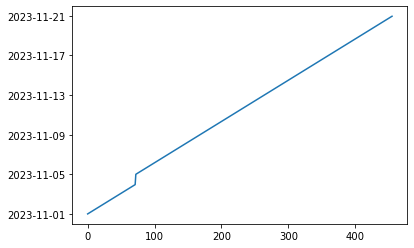

In [5]:
''' convert time to (1) datetime & (2) timestamp for output '''
dtime = np.array([datetime.datetime(1900,12,31)+datetime.timedelta(days=item) for item in vars_dic['MT']])
time_out = np.array( [item.timestamp() for item in dtime] )
plt.plot(dtime)
print(vars_dic['V_VELOCITY'].shape)
### Also check DATE in the nc file!
ds = nc.Dataset( path+data_type+file_dates[f]+'.nc')
test = ds.variables['DATE'][:]
print('check time of',data_type+file_dates[f]+'.nc :\n',test)

In [6]:
''' Write merged RTOFS data to netcdf file'''
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfname_out = 'RTOFS.merge.'+data_type+dtime[0].strftime('%Y%m%d')+'-'\
    +dtime[-1].strftime('%Y%m%d')+'.nc'
print('Creating a new file:',ncfname_out)
ncfile = nc.Dataset(ncfname_out,mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
### creating dimensions
time_dim = ncfile.createDimension('time', len(dtime)) # unlimited axis (can be appended to).
depth_dim = ncfile.createDimension('depth', len(vars_dic['LAYER'])) # depth axis
lon_dim = ncfile.createDimension('longitude', vars_dic['U_VELOCITY'].shape[3])
lat_dim = ncfile.createDimension('latitude', vars_dic['U_VELOCITY'].shape[2])
for dim in ncfile.dimensions.items():
    print(dim)
### creating attributes
ncfile.title='Merged files for RTOFS from'+data_type+file_dates[0]+'.nc'+' to '+\
    ' and '+data_type+file_dates[-1]+'.nc \n'+\
    'Note that the time of each daily file in /Volumes/disk3/projects/tc2022/tc2023/RTOFS/study_area/ \n'+\
        'is one day prior to the date on showing in the filename. \n'+\
            'EX: the 24 hours of data in surface.now.20230801.nc is 2023/07/31 0Z to 23Z.\n'+\
    'The actual time range of this file is as the filename.'
print(ncfile.title)
ncfile.subtitle="Only selected variables for are merged here. The data is hourly with 0.08 deg horizontal resolution."
print(ncfile.subtitle)
print(ncfile)
### move the writing data to new variables
depth_out = vars_dic['LAYER']

Creating a new file: RTOFS.merge.surface.now.20231101-20231120.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 456)
('depth', <class 'netCDF4._netCDF4.Dimension'>: name = 'depth', size = 1)
('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 901)
('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 551)
Merged files for RTOFS fromsurface.now.20231102.nc to  and surface.now.20231121.nc 
Note that the time of each daily file in /Volumes/disk3/projects/tc2022/tc2023/RTOFS/study_area/ 
is one day prior to the date on showing in the filename. 
EX: the 24 hours of data in surface.now.20230801.nc is 2023/07/31 0Z to 23Z.
The actual time range of this file is as the filename.
Only selected variables for are merged here. The data is hourly with 0.08 deg horizontal 

In [7]:
### Creating variables
depth = ncfile.createVariable('depth', np.float64, ('depth',))
depth.units = 'meter'
depth.long_name = 'depth'
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since '+year+'-01-01'
time.long_name = 'time'
vars_names = ['LONGITUDE','LATITUDE','U_VELOCITY','V_VELOCITY','MIXED_LAYER_THICKNESS']
### 2: (Y, X) 3: (time, Y, X) 4: (time, depth, Y, X)
dim_cat = [2,2,4,4,3]
for i, var_name in enumerate(vars_names):
    print(var_name)
    ### create variables with respective dimensions categorized by dim_cat
    if dim_cat[i] == 2:
        str_exec = var_name + "= ncfile.createVariable('" + var_name + "', np.float64, ('" + 'latitude' + "','"+ 'longitude' +"'))"
    elif dim_cat[i] == 3:
        str_exec = var_name + "= ncfile.createVariable('" + var_name + \
                    "', np.float64, ('" + 'time' + "','"+ 'latitude' + "','" + 'longitude' +"'))"
    elif dim_cat[i] == 4:
        str_exec = var_name + "= ncfile.createVariable('" + var_name + \
                    "', np.float64, ('" + 'time' + "','"+ 'depth' + "','"+ 'latitude' + "','" + 'longitude' +"'))"
    exec(str_exec)
    print(i,str_exec)
    ### add attributes
attr_keys = vars_dic_attr.keys()
str_no = ['MT','LAYER']
for attr_key in attr_keys:
    i_ = attr_key.find('-')
    if attr_key[:i_] not in str_no:
        str_exec = attr_key.replace('-','.') + " = '"+ str(vars_dic_attr[attr_key]) + "'"
        exec(str_exec)

LONGITUDE
0 LONGITUDE= ncfile.createVariable('LONGITUDE', np.float64, ('latitude','longitude'))
LATITUDE
1 LATITUDE= ncfile.createVariable('LATITUDE', np.float64, ('latitude','longitude'))
U_VELOCITY
2 U_VELOCITY= ncfile.createVariable('U_VELOCITY', np.float64, ('time','depth','latitude','longitude'))
V_VELOCITY
3 V_VELOCITY= ncfile.createVariable('V_VELOCITY', np.float64, ('time','depth','latitude','longitude'))
MIXED_LAYER_THICKNESS
4 MIXED_LAYER_THICKNESS= ncfile.createVariable('MIXED_LAYER_THICKNESS', np.float64, ('time','latitude','longitude'))


In [8]:
### writing data
# Note: the ":" is necessary in these "write" statements
depth[:] = vars_dic['LAYER']
time[:] = time_out
for i, var_name in enumerate(vars_names):
    if dim_cat[i] == 2:
        str_exec = var_name + "[:,:]= vars_dic['" + var_name + "']"
    elif dim_cat[i] == 3:
        str_exec = var_name + "[:,:,:]= vars_dic['" + var_name + "']"
    elif dim_cat[i] == 4:
        str_exec = var_name + "[:,:,:,:]= vars_dic['" + var_name + "']"
    exec(str_exec)
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for RTOFS fromsurface.now.20231102.nc to  and surface.now.20231121.nc 
Note that the time of each daily file in /Volumes/disk3/projects/tc2022/tc2023/RTOFS/study_area/ 
is one day prior to the date on showing in the filename. 
EX: the 24 hours of data in surface.now.20230801.nc is 2023/07/31 0Z to 23Z.
The actual time range of this file is as the filename.
    subtitle: Only selected variables for are merged here. The data is hourly with 0.08 deg horizontal resolution.
    dimensions(sizes): time(456), depth(1), longitude(901), latitude(551)
    variables(dimensions): float64 depth(depth), float64 time(time), float64 LONGITUDE(latitude, longitude), float64 LATITUDE(latitude, longitude), float64 U_VELOCITY(time, depth, latitude, longitude), float64 V_VELOCITY(time, depth, latitude, longitude), float64 MIXED_LAYER_THICKNESS(time, latitude, longitude)
    groups: 
Dataset 

In [9]:
print(vars_dic['MIXED_LAYER_THICKNESS'].shape)

(456, 551, 901)
